In [15]:
# This file predicts Arrests using AdaBoost (GridSearched to find best params).
# Dataset: crimes.csv merged with poverty.csv

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('crimes.csv')

In [2]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)
poverty.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [3]:
# Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Location Description', 'Arrest', 'Domestic', 'Community Area', 'Year']
data = df[useful_columns]

In [4]:
# Merge with the poverty dataframe
data.rename(columns={'Community Area': 'Community Area Number'}, inplace=True)
data = pd.merge(data, poverty, how='right', on='Community Area Number')

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [5]:
from sklearn.preprocessing import LabelEncoder
features = ['IUCR', 'Location Description', 'Arrest', 'Domestic']
for a in features:
    le = LabelEncoder()
    le.fit(data[a])
    data[a] = le.transform(data[a])
data.head()

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,312,133,0,1,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
1,81,149,1,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
2,41,153,0,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
3,257,149,1,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0
4,41,153,0,0,30.0,2012,15.2,30.7,15.8,54.8,33.8,10402,96.0


In [6]:
from sklearn.cross_validation import train_test_split

data = data.dropna()
X = data.drop(['Arrest'], axis=1)
y = data['Arrest'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [7]:
# Helper functions
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Arrest', 'Arrest'], rotation=45)
    plt.yticks(tick_marks, ['No Arrest', 'Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    predictions = [x[1] for x in predictions]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [10]:
# Helper functions
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from __future__ import division

def cm_loss(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    return (no_acc + yes_acc)/2

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Arrest', 'No Arrest'], rotation=45)
    plt.yticks(tick_marks, ['Arrest', 'No Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def accuracies(cm):
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    print("Arrest Acc: {0}".format(no_acc))
    print("No Arrest Acc: {0}".format(yes_acc))
    print("Avg Acc: {0}".format((no_acc + yes_acc)/2))

In [ ]:
# AdaBoost with default params
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
model = AdaBoostClassifier(n_estimators=5, learning_rate=.1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)
accuracies(cm)

In [18]:
# Order of importance
fi = zip(X_train.columns, best_model.feature_importances_)
fi_sort = sorted(fi, key=lambda (x,y): y, reverse=True)
fi_sort

[('IUCR', 1.0),
 ('Location Description', 0.0),
 ('Domestic', 0.0),
 ('Community Area Number', 0.0),
 ('Year', 0.0),
 ('PERCENT OF HOUSING CROWDED', 0.0),
 ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.0),
 ('PERCENT AGED 16+ UNEMPLOYED', 0.0),
 ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 0.0),
 ('PERCENT AGED UNDER 18 OR OVER 64', 0.0),
 ('PER CAPITA INCOME ', 0.0),
 ('HARDSHIP INDEX', 0.0)]

In [ ]:
# TODO: in progress
model = AdaBoostClassifier()
parameters = {'n_estimators':[50, 500, 5000], 'learning_rate': [.001, .01, .1]}
clf = GridSearchCV(model, parameters, scoring=cm_loss, cv=5, verbose=100)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
best_model = clf.best_estimator_

In [ ]:
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)
accuracies(cm)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished


[[1157153  122505]
 [ 134385  376061]]
Arrest Acc: 0.904267390193
No Arrest Acc: 0.736730231993
Avg Acc: 0.820498811093


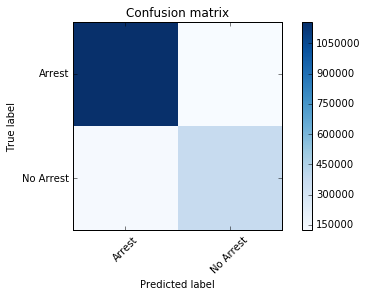

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
model = RandomForestClassifier(verbose=True, class_weight='balanced')

model.fit(X_train, y_train)
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)
accuracies(cm)

In [12]:
# Order of importance
fi = zip(X_train.columns, model.feature_importances_)
fi_sort = sorted(fi, key=lambda (x,y): y, reverse=True)
fi_sort

[('IUCR', 0.69742325342208322),
 ('Location Description', 0.14934291330513164),
 ('Year', 0.092673025038127216),
 ('Domestic', 0.016400121172657066),
 ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.0089231296252921845),
 ('HARDSHIP INDEX', 0.0071483073044732144),
 ('PERCENT AGED 16+ UNEMPLOYED', 0.0064410914412313443),
 ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 0.0048745474358741032),
 ('PERCENT AGED UNDER 18 OR OVER 64', 0.0042616280755334024),
 ('Community Area Number', 0.0042441004000877578),
 ('PERCENT OF HOUSING CROWDED', 0.0041623822491154679),
 ('PER CAPITA INCOME ', 0.0041055005303935041)]